# Loading data from pickle 

In [0]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import csv
import random
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
%matplotlib inline

def load_traffic_sign_data(training_file, testing_file, validation_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    return train, test, valid

# Load pickled data
train, test, valid = load_traffic_sign_data("./train.p", "./test.p", "./valid.p")
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [2]:

n_train, n_test = X_train.shape[0], X_test.shape[0]
image_shape = X_train[0].shape
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


# Exploring datased
Visualize all sign types. Plot image distribution for train and test set.

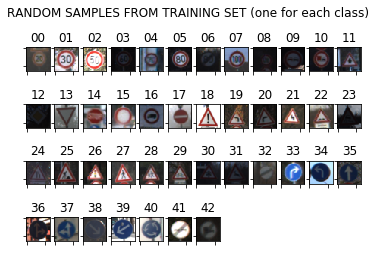

In [3]:

rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols)
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')

for class_idx, ax in enumerate(ax_array.ravel()):
  if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
  else:
      ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

In [4]:
id_to_name = dict()

with open('./signnames.csv', 'r') as names_csv:
  reader = csv.reader(names_csv, delimiter=',')
  next(reader)
  id_to_name = {int(row[0]):row[1] for row in reader}
  names_csv.close()
  
print(id_to_name)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

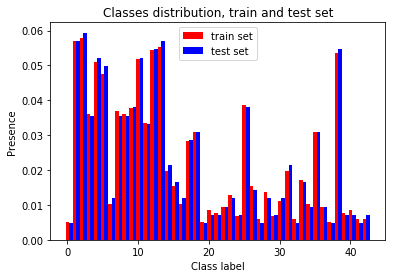

In [5]:
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)

for c in range(n_classes):
  train_distribution[c] = np.sum(y_train == c) / n_train
  test_distribution[c] = np.sum(y_test == c) / n_test
  
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes) + col_width, test_distribution, width=col_width, color='b')

ax.set_ylabel('Presence')
ax.set_xlabel('Class label')
ax.set_title('Classes distribution, train and test set')
ax.legend(('train set', 'test set'))
plt.show()

# Design and test model arhitecture

##Pre-processing images
*   Normalization
*   Gray scale
*   Equalize histagram
*  CLAHE - Contrast Limited Adaptive Histogram Equalization




In [0]:
def normalization(img):
  return (img - np.mean(img)) / np.std(img)

def to_gray(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def histagram_equalize(img):
  return cv2.equalizeHist(img)

def clahe(img):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(img)

In [0]:
def preprocess(imgs, labels):
  gray_imgs = list(map(to_gray, imgs))
  eq_imgs = list(map(clahe, gray_imgs))
  final_preprocessed_imgs = list(map(normalization, eq_imgs))
  x_imgs, x_labels = shuffle(final_preprocessed_imgs, labels)
  
  return x_imgs, x_labels

In [0]:
X_train_preprocessed, y_train_preprocessed = preprocess(X_train, y_train)
X_valid, y_valid = preprocess(X_valid, y_valid)
X_test, y_test = preprocess(X_test, y_test)

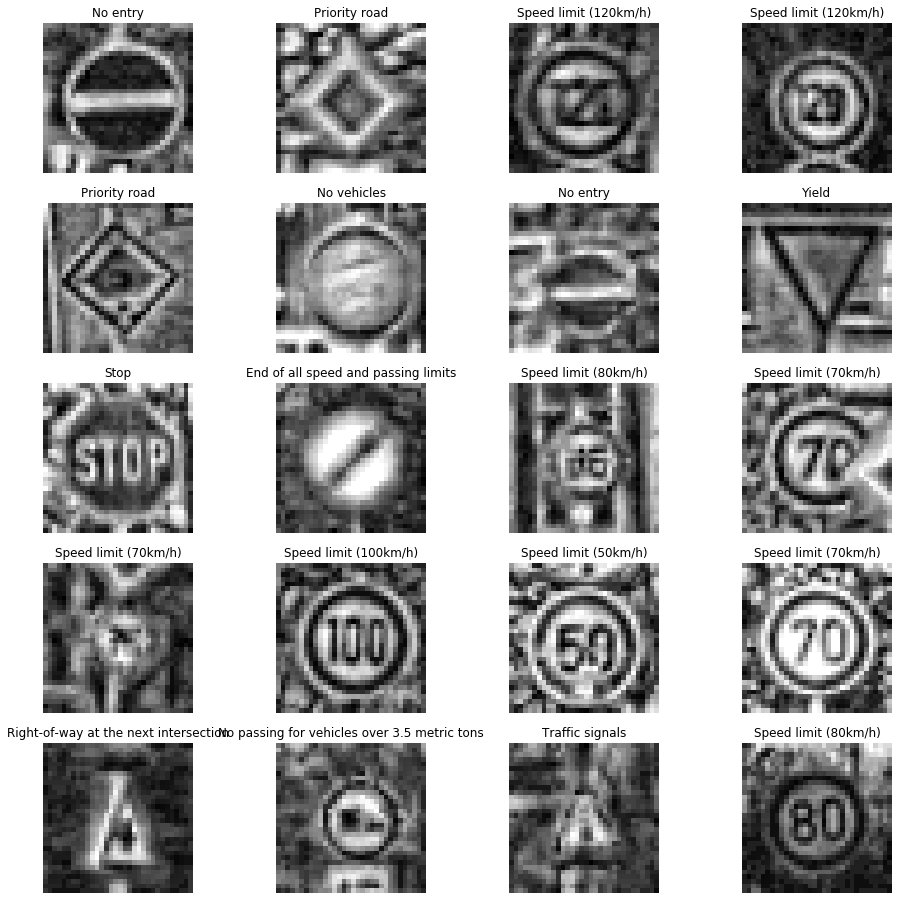

In [9]:
def display_mult(img_list, label_list, pred_list=[], columns=4, rows=5, cmap=''):        
    fig = plt.figure(figsize=(16,16));
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)       
        img = img_list[i-1]
        title =''
        if len(pred_list) > 0 :
            title = 'A:' + str(id_to_name[label_list[i-1]])
            title += '\n/P:' + str(id_to_name[pred_list[i-1]])
        else:
            title = id_to_name[label_list[i-1]]
        plt.title(title)
        plt.axis('off')
        if cmap != '':
            plt.imshow(img, cmap=cmap)
        else:
            plt.imshow(img)
    plt.show()
    

image_list = list()
label_list = list()
for i in range(20):
    indx = random.randint(0, len(X_train_preprocessed))
    image_list.append(X_train_preprocessed[indx])
    label_list.append(y_train_preprocessed[indx])

display_mult(image_list, label_list, cmap='gray')

## Model arhitecture


*   **LeNet**
*   **VGG16**



In [0]:
from tensorflow.contrib.layers import flatten

initializer = tf.contrib.layers.xavier_initializer()

def LeNet(x, dropout=False):
  
  # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
  # 5x5 filter, input depth=1, output depth=6
  conv_w1 = tf.Variable(initializer(shape=(5, 5, 1, 6)))
  conv_b1 = tf.Variable(tf.zeros(6))
  conv_1 = tf.nn.conv2d(x, conv_w1, strides=[1,1,1,1], padding='VALID') + conv_b1
  
  # Activation
  conv_1 = tf.nn.relu(conv_1)
  
  # Pooling 1: Input = 28x28x6. Output = 14x14x6
  conv_1 = tf.nn.max_pool(conv_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
  if dropout:
    conv_1 = tf.nn.dropout(conv_1, keep_probs)
    
  # Layer 2: Convolution. Input = 14x14x6. Output = 10x10x16
  conv_w2 = tf.Variable(initializer(shape=(5, 5, 6, 16)))
  conv_b2 = tf.Variable(tf.zeros(16))
  conv_2 = tf.nn.conv2d(conv_1, conv_w2, strides=[1,1,1,1], padding='VALID') + conv_b2
  
  # Activation
  conv_2 = tf.nn.relu(conv_2)
  
  # Polling 2: Input = 10x10x16. Output = 5x5x16
  conv_2 = tf.nn.max_pool(conv_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
  if dropout:
    conv_2 = tf.nn.dropout(conv_2, keep_probs)
    
    
  # Flatten. Input = 5x5x16. Output = 400
  fc0 = flatten(conv_2)
  #fc0 = keras.layers.flatten(conv_2)
  
  # Layer 3: Fully connected. Input = 400. Output = 120
  fc1_w = tf.Variable(initializer(shape=(400, 120)))
  fc1_b = tf.Variable(tf.zeros(120))
  fc1 = tf.add(tf.matmul(fc0, fc1_w),fc1_b)
  
  # Activation
  fc1 = tf.nn.relu(fc1)
  if dropout:
    fc1 = tf.nn.dropout(fc1, keep_probs)
    
  # Layer 4: Fully connected. Input = 120. Output = 84
  fc2_w = tf.Variable(initializer(shape=(120, 84)))
  fc2_b = tf.Variable(tf.zeros(84))
  fc2 = tf.add(tf.matmul(fc1, fc2_w), fc2_b)
  
  # Activation
  fc2 = tf.nn.relu(fc2)
  if dropout:
    fc2 = tf.nn.dropout(fc2, keep_probs)
    
  # Layer 5: Fully connected. Input = 84. Output = n_classes
  fc3_W  = tf.Variable(initializer(shape=(84, n_classes)))
  fc3_b  = tf.Variable(tf.zeros(n_classes))
  logits = tf.add(tf.matmul(fc2, fc3_W), fc3_b)
  
  
  return logits

In [13]:
EPOCHS = 50
BATCH_SIZE = 128
rate = 1e-3

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_probs = tf.placeholder(tf.float32)

logits = LeNet(x, True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [0]:
def evaluate(X_data, y_data, prob=0):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        if prob > 0:
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_probs:prob})
            loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_probs:prob})
        else: # Don't use dropout for validation
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

In [24]:
train_accs = []
train_losses = []
valid_accs = []
valid_losses = []
best_acc = 0

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  print("Training...\n")
  train_loss = 0.0
  train_acc = 0.0
  
  for i in range(EPOCHS):
    for offset in range(0, n_train, BATCH_SIZE):
      end = offset + BATCH_SIZE
      batch_x = X_train_preprocessed[offset : end]
      batch_y = y_train_preprocessed[offset: end]
      batch_x = np.reshape(batch_x, (-1, 32, 32, 1))
      sess.run(training_operation, feed_dict={x: batch_x, y:batch_y, keep_probs:0.8})
      
      train_loss = sess.run(loss_operation, feed_dict={x: batch_x, y:batch_y, keep_probs:0.8})
      train_acc = sess.run(accuracy_operation, feed_dict={x: batch_x, y:batch_y, keep_probs:0.8})
      
    # End of epoch
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    # Validate after each epoch
    X_valid = np.reshape(X_valid, (-1, 32, 32, 1))
    valid_acc, valid_loss = evaluate(X_valid, y_valid, prob=1.0)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_acc > best_acc:
      best_acc = valid_acc
      saver.save(sess, './lenet')
      print("Model saved")
      
    print("EPOCH {} ...".format(i+1))
    print("Training Loss: {:.4f}, Training Accuracy = {:.3f}".format(train_loss, train_acc * 100))
    print("Validation Loss: {:.4f}, Validation Accuracy = {:.3f}".format(valid_loss, valid_acc*100))
    print()

Training...

Model saved
EPOCH 1 ...
Training Loss: 0.8365, Training Accuracy = 74.775
Validation Loss: 0.7787, Validation Accuracy = 79.728

Model saved
EPOCH 2 ...
Training Loss: 0.5428, Training Accuracy = 90.090
Validation Loss: 0.3926, Validation Accuracy = 87.347

Model saved
EPOCH 3 ...
Training Loss: 0.5145, Training Accuracy = 89.189
Validation Loss: 0.2573, Validation Accuracy = 90.091

Model saved
EPOCH 4 ...
Training Loss: 0.3556, Training Accuracy = 90.991
Validation Loss: 0.2198, Validation Accuracy = 91.587

Model saved
EPOCH 5 ...
Training Loss: 0.2481, Training Accuracy = 91.892
Validation Loss: 0.1775, Validation Accuracy = 93.061

Model saved
EPOCH 6 ...
Training Loss: 0.2680, Training Accuracy = 95.495
Validation Loss: 0.1452, Validation Accuracy = 94.127

Model saved
EPOCH 7 ...
Training Loss: 0.1366, Training Accuracy = 96.396
Validation Loss: 0.1448, Validation Accuracy = 94.739

Model saved
EPOCH 8 ...
Training Loss: 0.1251, Training Accuracy = 92.793
Validation

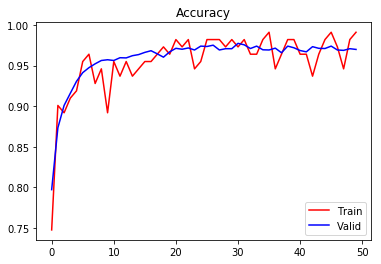

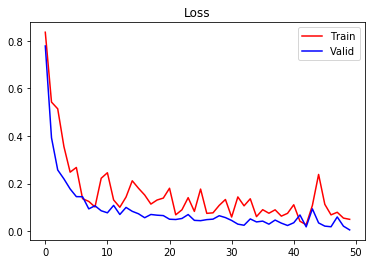

In [26]:
plt.plot(train_accs, color='red', label='Train')
plt.plot(valid_accs, color='blue', label='Valid')
plt.title('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(train_losses, color='red', label='Train')
plt.plot(valid_losses, color='blue', label='Valid')
plt.title('Loss')
plt.legend(loc='best')
plt.show()

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_reshaped = np.reshape(X_test, (-1, 32, 32, 1))
    test_accuracy, test_loss = evaluate(test_reshaped, y_test, 1.0)
    print("Test Loss = {:.4f}, Test Accuracy = {:.3f}".format(test_loss, test_accuracy * 100))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
Test Loss = 0.1798, Test Accuracy = 95.487


## VGG16